# Exercício 3 - NLP

### Questão 1

Objetivo: prever se uma mensagem é spam ou não.

a) Qual porcentagem dos documentos são spam?

b) Usando mala de palavras (CountVectorizer), qual é o token mais longo do vocabulário dos dados de treinamento? Utilize o modelo de classificação multinomial Naive Bayes e encontre a (AUC) usando os dados de teste.

c) Utilize o vetorizador Tf-idf nos dados de treinamento. Quais 20 características têm o menor tf-idf e quais 20 têm o maior tf-idf? Coloque essas características em duas séries, onde cada série é classificada pelo valor tf-idf e, em seguida, em ordem alfabética pelo nome da característica. O índice da série deve ser o nome da característica e os dados devem ser o tf-idf. A série de 20 características com o menor tf-idfs deve ser classificada de forma crescente, a lista de 20 características com o maior tf-idfs deve ser classificada de forma decrescente.

d) Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 3. Use o modelo classificador multinomial Naive Bayes com alfa = 0.1, e então calcule a pontuação AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro alfa e descreva brevemente como esse parâmetro se comporta no modelo.

e) Qual é o tamanho médio dos documentos (número de caracteres) para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5. Usando essa matriz de termos de documento e um característica  adicional (o comprimento do documento (número de caracteres)), treine um modelo SVC, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

f) Qual é o número médio de dígitos por documento para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando essa matriz de termos de documento e duas características  adicionais (o comprimento do documento e o número médio de dígitos por documento) treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

g) Qual é o número médio de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore) por documento para documentos não-spam e documentos spam? Dica: use as classes de caracteres \w e \W do pacote re (regular expressions). Utilize o vetorizador CountVectorizer nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando esta matriz de termos de documento e as seguintes características adicionais: o comprimento do documento, número de dígitos por documento, e o número de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore), treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo. Encontre os 10 menores e os 10 maiores coeficientes do modelo e retorne-os juntamente com a pontuação da AUC em uma tupla. A lista dos 10 menores coeficientes deve ser classificada de forma crescente, a lista dos 10 maiores coeficientes de forma decrescente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import sklearn.metrics as metrics


In [3]:
# constants
DATA_DIR = 'CSV'
SPAM_FILE = 'spam.csv'
NEWS_FILE = 'newsgroups.txt'

NOT_WORDS = 'not_words'
DIGITS = 'digits'
DOC_SIZE = 'doc_size'

In [4]:
spam_data = pd.read_csv(os.path.join(DATA_DIR, SPAM_FILE))

spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head(10)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


# Preparação dos dados

### Tendo em vista os pedidos subsequentes, realizarei uma preparação do dataframe para ser capaz de responder a todos os ítens mais facilmente.

In [5]:
# Retorna os caracteres que não compõem palavras
def non_word_chars(chunk):
    return re.findall('\W', chunk)

# retorna o número de dígitos em uma string (usaremos sobre documentos documents)
def count_digits(chunk):
    return len(re.findall('\d', chunk))

# Retorna estatísticas sobre uma característica
def feature_stats(df, feature, spam=1):
    return spam_data[spam_data.target == spam].loc[:,[feature]].describe().T

# Exibe a curva ROC com o valor de AUC
def plot_roc_auc(y_test, probs):
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.roc_auc_score(y_test, probs)

    plt.figure(figsize=(12,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

# Script para avaliar diversos valores de um parâmetro com um modelo. Referência documentada abaixo.
def tune_parameters(Xtrain, ytrain, Xtest, ytest, params, model):
    """ Parameter estimation using grid search with cross-validation
          Avaiable at: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html"""
    
    tuned_parameters = params

    scores = ['roc_auc']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(model, tuned_parameters, cv=5,
                           scoring=score)
        clf.fit(Xtrain, ytrain)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = ytest, clf.predict(Xtest)
        print(metrics.classification_report(y_true, y_pred))
        print()

In [6]:
# tamanho de cada documento
spam_data[DOC_SIZE] = spam_data.text.apply(lambda x: len(x))
# número de caracteres que não compõem palavras
spam_data[NOT_WORDS] = spam_data.text.apply(lambda x: len(non_word_chars(x)))
# número de dígitos no documento
spam_data[DIGITS] = spam_data.text.apply(count_digits)

In [7]:
spam_data.head(10)

,text,target,doc_size,not_words,digits
0,"Go until jurong point, crazy.. Available only ...",0,111,28,0
1,Ok lar... Joking wif u oni...,0,29,11,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,33,25
3,U dun say so early hor... U c already then say...,0,49,16,0
4,"Nah I don't think he goes to usf, he lives aro...",0,61,14,0
5,FreeMsg Hey there darling it's been 3 week's n...,1,148,40,4
6,Even my brother is not like to speak with me. ...,0,77,17,0
7,As per your request 'Melle Melle (Oru Minnamin...,0,160,31,1
8,WINNER!! As a valued network customer you have...,1,158,32,19
9,Had your mobile 11 months or more? U R entitle...,1,154,30,13


## a) Qual porcentagem dos documentos são spam?

In [8]:
spam_data.target.unique()

array([0, 1])

Os únicos valores presentes na série "target" são 0 e 1. Os documentos classificados como spam possuem valor 1 nesta série. Assim sendo, podemos obter o percentual de spam da base com uma simples soma e divisão

In [9]:
spam_ratio = spam_data.target.sum()/spam_data.target.size
print('=> O percentual de documentos que são spam é {0:.2f}%'.format(spam_ratio*100))

=> O percentual de documentos que são spam é 13.41%


## Usando mala de palavras (CountVectorizer), qual é o token mais longo do vocabulário dos dados de treinamento?

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)

In [11]:
cv = CountVectorizer()
bow_train = cv.fit_transform(X_train)
bow_train.shape

(4179, 7354)

In [12]:
tokens = cv.get_feature_names()
tokens.sort(key=len, reverse=True)
print("=> O token mais longo do vocabulário dos dados de treinamento é: {} ({} caracteres)".format(
    tokens[0], len(tokens[0])))
print("Para referência, o segundo maior é: {}".format(tokens[1]))

=> O token mais longo do vocabulário dos dados de treinamento é: com1win150ppmx3age16subscription (32 caracteres)
Para referência, o segundo maior é: minmoremobsemspobox45po139wa


## Utilize o modelo de classificação multinomial Naive Bayes e encontre a (AUC) usando os dados de teste.

In [13]:
mnb_model = MultinomialNB()
mnb_model.fit(bow_train, y_train)
# Aplica a mesma transformação aos dados de teste para garantir compatibilidade de dimensões 
# (uso dos mesmos tokens como características)
bow_test = cv.transform(X_test)
# mantém apenas a probabilidade de ser spam 
probs = mnb_model.predict_proba(bow_test)[:, 1]

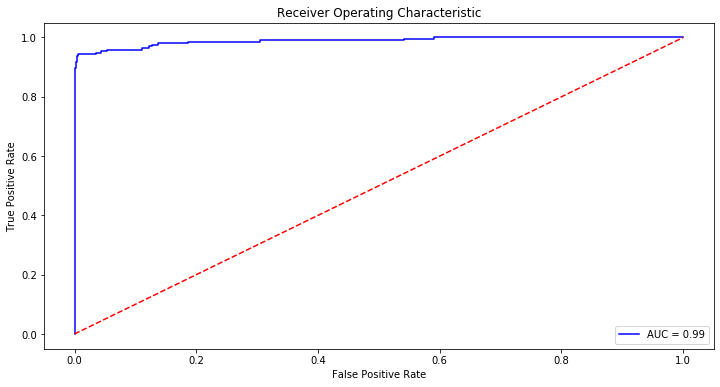

AUC: 0.9884004210311869


In [14]:
auc = plot_roc_auc(y_test, probs)
print("AUC: {}".format(auc))

## c) Utilize o vetorizador Tf-idf nos dados de treinamento. 

In [15]:
tfidf_vectorizer = TfidfVectorizer()
train_matrix = tfidf_vectorizer.fit_transform(X_train)
train_matrix.shape

(4179, 7354)

## Quais 20 características têm o menor tf-idf e quais 20 têm o maior tf-idf? Coloque essas características em duas séries, onde cada série é classificada pelo valor tf-idf e, em seguida, em ordem alfabética pelo nome da característica. O índice da série deve ser o nome da característica e os dados devem ser o tf-idf. A série de 20 características com o menor tf-idfs deve ser classificada de forma crescente, a lista de 20 características com o maior tf-idfs deve ser classificada de forma decrescente.

In [16]:
features = np.array(tfidf_vectorizer.get_feature_names())
tfidf_sorted = np.sort(train_matrix.toarray()).flatten()
sorting_indices = np.argsort(train_matrix.toarray()).flatten()

In [17]:
limit = 20
df_lowest = pd.Series(tfidf_sorted[:limit], index=features[sorting_indices][:limit])[::-1]
df_highest = pd.Series(tfidf_sorted[-limit:], index=features[sorting_indices][-limit:])[::-1]

In [18]:
print("=> 20 características com menor tf-idf:")
df_lowest

=> 20 características com menor tf-idf:


petey              0.0
petrol             0.0
petticoatdreams    0.0
pg                 0.0
ph                 0.0
pharmacy           0.0
phd                0.0
photo              0.0
phews              0.0
phil               0.0
philosophical      0.0
philosophy         0.0
phne               0.0
phoenix            0.0
phone              0.0
phonebook          0.0
phoned             0.0
phones             0.0
phony              0.0
00                 0.0
dtype: float64

In [19]:
print("=> 20 características com maior tf-idf:")
df_highest

=> 20 características com maior tf-idf:


wont           0.565857
dare           0.347443
stupid         0.311998
you            0.305559
hear           0.275090
talk           0.258698
anything       0.241310
after          0.225107
tell           0.213221
to             0.197660
how            0.179845
ended          0.000000
emergency      0.000000
else           0.000000
elsewhere      0.000000
em             0.000000
email          0.000000
enemy          0.000000
embarassed     0.000000
embarassing    0.000000
dtype: float64

## d) Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 3. 

In [20]:
# Alterei a expressão regular padrão, que ignora termos menores que 2, para ignorar termos menores que 3 caracteres
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w\w\w+\b")
train_matrix = tfidf_vectorizer.fit_transform(X_train)

## Use o modelo classificador multinomial Naive Bayes com alfa = 0.1, e então calcule a pontuação AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro alfa e descreva brevemente como esse parâmetro se comporta no modelo.

In [21]:
test_matrix = tfidf_vectorizer.transform(X_test)
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(train_matrix, y_train)
probs = mnb_model.predict_proba(test_matrix)[:, 1]

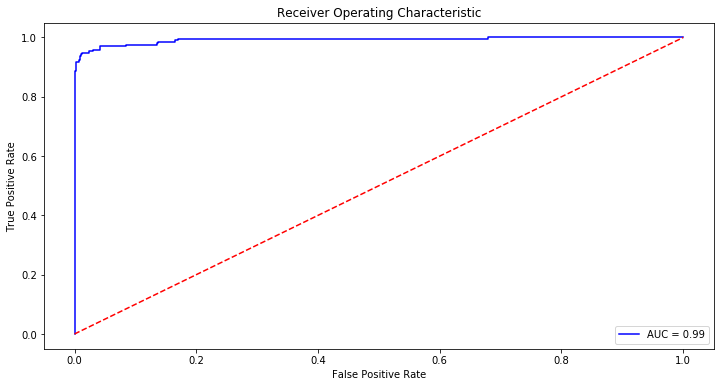

AUC: 0.9919783372663531


In [22]:
print("AUC:", plot_roc_auc(y_test, probs))

In [23]:
tune_parameters(train_matrix, y_train, test_matrix, y_test, 
                {'alpha':[0.00001*10**v for v in range(10)]}, 
                mnb_model)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'alpha': 0.1}

Grid scores on development set:

0.984 (+/-0.017) for {'alpha': 1e-05}
0.986 (+/-0.015) for {'alpha': 0.0001}
0.988 (+/-0.013) for {'alpha': 0.001}
0.990 (+/-0.010) for {'alpha': 0.01}
0.991 (+/-0.010) for {'alpha': 0.1}
0.981 (+/-0.015) for {'alpha': 1.0}
0.937 (+/-0.029) for {'alpha': 10.0}
0.858 (+/-0.040) for {'alpha': 100.00000000000001}
0.822 (+/-0.043) for {'alpha': 1000.0000000000001}
0.816 (+/-0.043) for {'alpha': 10000.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1196
           1       0.99      0.89      0.94       197

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393

=> Com a função "tune_parameters", construída a partir de um script de *Grid Search* disponível na documentação do Sci-Kit Learn, é possível automatizar uma avaliação do modelo com diferentes valores de um ou mais hiperparâmetros e com *validação cruzada*. No caso do classificador multinomial Naive Bayes, observa-se que os melhores valores estão no entorno de 0.1, tanto se considerarmos o maior valor obtido para a métrica AUC, quanto se olharmos para a variância do resultado, que é menor. Valores muito altos de alfa diminuem a eficácia do classificador.

## e) Qual é o tamanho médio dos documentos (número de caracteres) para documentos não-spam e documentos spam? 

In [24]:
df = feature_stats(spam_data, DOC_SIZE, spam=1)
print('=> Média do tamanho dos documentos que são SPAM: {:.2f}'.format(df.loc[DOC_SIZE,'mean']))
df

=> Média do tamanho dos documentos que são SPAM: 138.87


,count,mean,std,min,25%,50%,75%,max
doc_size,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0


In [25]:
df = feature_stats(spam_data, DOC_SIZE, spam=0)
print('=> Média do tamanho dos documentos que NÃO são SPAM: {:.2f}'.format(df.loc[DOC_SIZE,'mean']))
df

=> Média do tamanho dos documentos que NÃO são SPAM: 71.02


,count,mean,std,min,25%,50%,75%,max
doc_size,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0


## Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5. Usando essa matriz de termos de documento e um característica adicional (o comprimento do documento (número de caracteres)), treine um modelo SVC, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

In [26]:
from scipy.sparse import hstack

In [27]:
docsize_train, docsize_test, = train_test_split(spam_data.doc_size, random_state=0)

In [28]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w\w\w\w\w+\b")
tfidf_matrix =  tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
print(tfidf_matrix.shape, tfidf_test.shape)

(4179, 5111) (1393, 5111)


In [29]:
# Vamos adicionar o comprimento dos documentos à matriz para uso no modelo SVC
train_features = hstack((tfidf_matrix, docsize_train.to_numpy()[:, None]))
test_features = hstack((tfidf_test, docsize_test.to_numpy()[:, None]))

In [30]:
svc_model = SVC(gamma='auto', probability=True)
svc_model.fit(train_features, y_train)
probs = svc_model.predict_proba(test_features)[:,1]

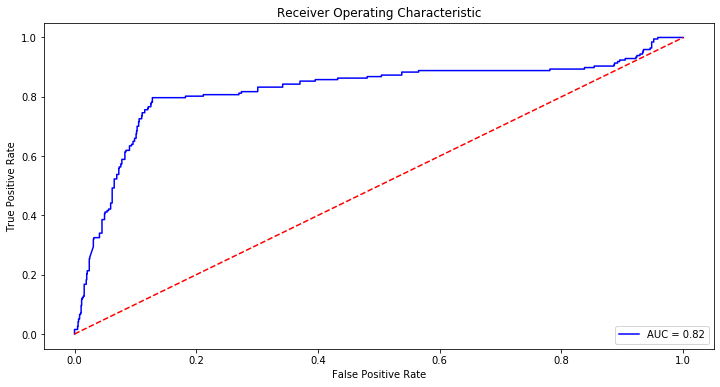

AUC: 0.8207540362969628


In [31]:
print("AUC:", plot_roc_auc(y_test, probs))

In [32]:
tune_parameters(train_features, y_train, test_features, y_test, 
                {'C':[0.00001*10**v for v in range(10)]}, 
                svc_model)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'C': 10000.0}

Grid scores on development set:

0.831 (+/-0.078) for {'C': 1e-05}
0.831 (+/-0.078) for {'C': 0.0001}
0.819 (+/-0.030) for {'C': 0.001}
0.824 (+/-0.024) for {'C': 0.01}
0.828 (+/-0.050) for {'C': 0.1}
0.833 (+/-0.046) for {'C': 1.0}
0.825 (+/-0.027) for {'C': 10.0}
0.910 (+/-0.019) for {'C': 100.00000000000001}
0.975 (+/-0.009) for {'C': 1000.0000000000001}
0.980 (+/-0.006) for {'C': 10000.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1196
           1       0.97      0.85      0.90       197

    accuracy                           0.97      1393
   macro avg       0.97      0.92      0.94      1393
weighted avg       0.97      0.97      0.97      1393




=> Observamos resultados mais eficazes para valores maiores de C em relação aos valores menores e até mesmo intermediários. Talvez a adição do tamanho dos documentos como característica a ser considerada pelo modelo possa ter causado maior dificuldade na convergência para uma boa solução, visto que são números com valores absolutos muito maiores que as demais características selecionadas. Neste sentido, penalizar com maior intensidade discrepâncias nos pesos do modelo podem favorecer um resultado melhor e, por isso, valores elevados para o hiperparâmetro C de regularização forneceram melhores resultados.

## f) Qual é o número médio de dígitos por documento para documentos não-spam e documentos spam? 

In [33]:
df = feature_stats(spam_data, DIGITS, spam=1)
print('=> Média do número de dígitos em documentos que são SPAM: {:.2f}'.format(df.loc[DIGITS,'mean']))
df

=> Média do número de dígitos em documentos que são SPAM: 15.76


,count,mean,std,min,25%,50%,75%,max
digits,747.0,15.759036,8.755896,0.0,10.0,16.0,22.0,47.0


In [34]:
df = feature_stats(spam_data, DIGITS, spam=0)
print('=> Média do número de dígitos em documentos que NÃO são SPAM: {:.2f}'.format(df.loc[DIGITS,'mean']))
df

=> Média do número de dígitos em documentos que NÃO são SPAM: 0.30


,count,mean,std,min,25%,50%,75%,max
digits,4825.0,0.299275,1.063086,0.0,0.0,0.0,0.0,23.0


## Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas.

In [35]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w\w\w\w\w+\b", ngram_range=(1,3))
tfidf_matrix =  tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
print(tfidf_matrix.shape, tfidf_test.shape)

(4179, 26353) (1393, 26353)


##  Usando essa matriz de termos de documento e duas características adicionais (o comprimento do documento e o número médio de dígitos por documento) treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

In [36]:
digits_train, digits_test = train_test_split(spam_data.digits, random_state=0)

train_features = hstack((tfidf_matrix, docsize_train.to_numpy()[:, None], digits_train.to_numpy()[:, None]))
test_features = hstack((tfidf_test, docsize_test.to_numpy()[:, None], digits_test.to_numpy()[:, None]))

In [37]:
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(train_features, y_train)
probs = lr_model.predict_proba(test_features)[:,1]

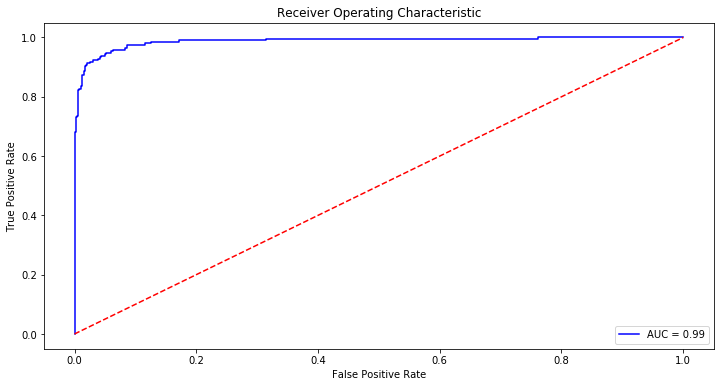

AUC: 0.9871950494881415


In [38]:
print("AUC:", plot_roc_auc(y_test, probs))

In [39]:
tune_parameters(train_features, y_train, test_features, y_test, 
                {'C':[0.00001*10**v for v in range(10)]}, 
                lr_model)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'C': 100.00000000000001}

Grid scores on development set:

0.347 (+/-0.056) for {'C': 1e-05}
0.804 (+/-0.058) for {'C': 0.0001}
0.860 (+/-0.054) for {'C': 0.001}
0.911 (+/-0.042) for {'C': 0.01}
0.959 (+/-0.035) for {'C': 0.1}
0.985 (+/-0.010) for {'C': 1.0}
0.989 (+/-0.010) for {'C': 10.0}
0.990 (+/-0.010) for {'C': 100.00000000000001}
0.990 (+/-0.010) for {'C': 1000.0000000000001}
0.990 (+/-0.010) for {'C': 10000.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1196
           1       0.97      0.88      0.92       197

    accuracy                           0.98      1393
   macro avg       0.97      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393




=>

## g) Qual é o número médio de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore) por documento para documentos não-spam e documentos spam? Dica: use as classes de caracteres \w e \W do pacote re (regular expressions). 

In [40]:
df = feature_stats(spam_data, NOT_WORDS, spam=1)
print('=> Média de caracteres que não são palavras, por documento, para documentos que são SPAM: {:.2f}'.format(
      df.loc[NOT_WORDS,'mean']))
df

=> Média de caracteres que não são palavras, por documento, para documentos que são SPAM: 29.04


,count,mean,std,min,25%,50%,75%,max
not_words,747.0,29.041499,7.319564,1.0,27.0,30.0,34.0,50.0


In [41]:
df = feature_stats(spam_data, NOT_WORDS, spam=0)
print('=> Média de caracteres que não são palavras, por documento, para documentos que NÃO são SPAM: {:.2f}'.format(
      df.loc[NOT_WORDS,'mean']))
df

=> Média de caracteres que não são palavras, por documento, para documentos que NÃO são SPAM: 17.29


,count,mean,std,min,25%,50%,75%,max
not_words,4825.0,17.291813,14.990677,0.0,8.0,13.0,22.0,253.0


## Utilize o vetorizador CountVectorizer nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. 

In [42]:
# O padrão de token utilizado como "default" ignora termos com tamanho menor ou igual a 2 caracteres. 
# Alterei este padrão para ignorar os termos com menos de 5 caracteres.
token_pattern=r"(?u)\b\w\w\w\w\w+\b"
counter = CountVectorizer(stop_words='english', ngram_range=(1, 3), token_pattern=token_pattern)
train_matrix = counter.fit_transform(X_train)
train_matrix.shape

(4179, 22661)

## Usando esta matriz de termos de documento e as seguintes características adicionais: o comprimento do documento, número de dígitos por documento, e o número de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore), treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo. 

In [43]:
not_words_train, not_words_test = train_test_split(spam_data.not_words, random_state=0)

# Transformação equivalente sobre os dados de teste para conseguirmos usar os mesmos tokens como features
test_matrix = counter.transform(X_test)

train_features = hstack((train_matrix, docsize_train.to_numpy()[:, None], 
                         digits_train.to_numpy()[:, None],
                        not_words_train.to_numpy()[:, None]))
test_features = hstack((test_matrix, docsize_test.to_numpy()[:, None], 
                        digits_test.to_numpy()[:, None],
                       not_words_test.to_numpy()[:, None]))

In [44]:
lr_model = LogisticRegression(random_state=0, solver='liblinear', C=1.0)
lr_model.fit(train_features, y_train)
probs = lr_model.predict_proba(test_features)[:, 1]

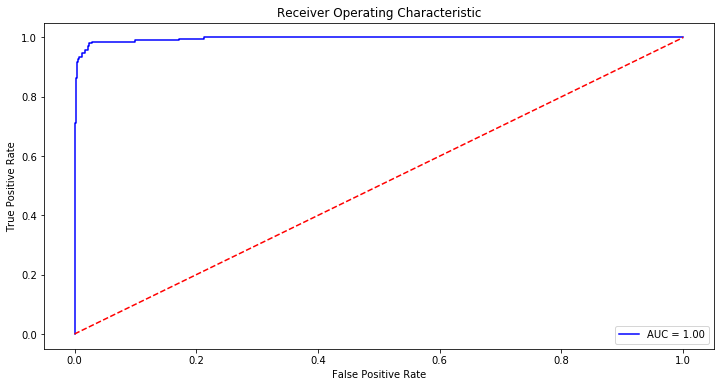

AUC: 0.9959764358351867


In [45]:
auc_value = plot_roc_auc(y_test, probs)
print("AUC:", auc_value)

In [46]:
tune_parameters(train_features, y_train, test_features, y_test, 
                {'C':[0.00001*10**v for v in range(10)]}, 
                lr_model)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.370 (+/-0.059) for {'C': 1e-05}
0.816 (+/-0.062) for {'C': 0.0001}
0.870 (+/-0.055) for {'C': 0.001}
0.927 (+/-0.049) for {'C': 0.01}
0.981 (+/-0.022) for {'C': 0.1}
0.992 (+/-0.011) for {'C': 1.0}
0.993 (+/-0.010) for {'C': 10.0}
0.993 (+/-0.010) for {'C': 100.00000000000001}
0.992 (+/-0.010) for {'C': 1000.0000000000001}
0.992 (+/-0.010) for {'C': 10000.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1196
           1       0.98      0.90      0.94       197

    accuracy                           0.98      1393
   macro avg       0.98      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393




=> O modelo apresenta os melhores resultados segundo a métrica AUC quando o hiperparâmetro de regularização C tem o valor entre 10 e 100. Valores ainda mais altos não prejudicaram muito o desempenho do modelo, porém valores abaixo de 0.1 apresentaram significativa perda da área abaixo da curva ROC, consequentemente, desequilibrando as taxas de falsos positivos e sensitividade do modelo para níveis mais baixos.

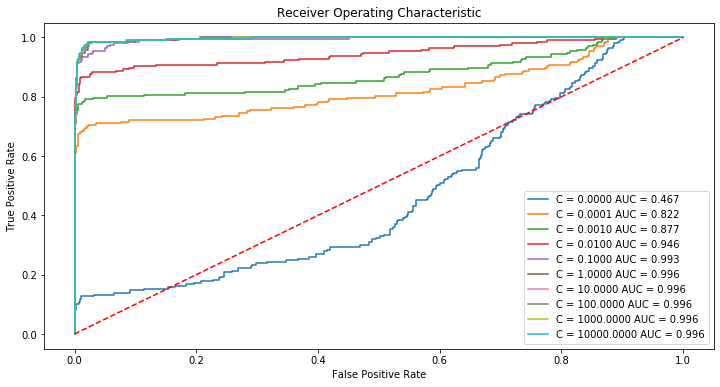

In [47]:
C_parameters = [0.00001*10**v for v in range(10)]
models = [LogisticRegression(solver='liblinear', C=c_parameter) for c_parameter in C_parameters]

fpr_array = []
tpr_array  = []
plt.figure(figsize=(12,6))
for model in models:
    model.fit(train_features, y_train)
    probs = model.predict_proba(test_features)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    fpr_array.append(fpr)
    tpr_array.append(tpr)
    roc_auc = metrics.roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label = 'C = {:.4f} AUC = {:.3f}'.format(model.C, roc_auc))

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Encontre os 10 menores e os 10 maiores coeficientes do modelo e retorne-os juntamente com a pontuação da AUC em uma tupla. A lista dos 10 menores coeficientes deve ser classificada de forma crescente, a lista dos 10 maiores coeficientes de forma decrescente.

In [48]:
sorted_coefs = np.sort(lr_model.coef_.flatten())
lowest_coefs = sorted_coefs[:10]
highest_coefs = sorted_coefs[::-1][:10]

In [49]:
print("=> Menores coeficientes:\n", (lowest_coefs, auc_value))
print("=> Maiores coeficientes:\n", (highest_coefs, auc_value))

=> Menores coeficientes:
 (array([-1.13821354, -0.9700185 , -0.9700185 , -0.9700185 , -0.9700185 ,
       -0.9700185 , -0.87911685, -0.49404817, -0.48943171, -0.47523942]), 0.9959764358351867)
=> Maiores coeficientes:
 (array([1.6198418 , 1.2628606 , 1.23143781, 1.20996881, 1.19789066,
       1.08095266, 0.91608317, 0.91608317, 0.91608317, 0.90411889]), 0.9959764358351867)


--------------------------------------------

### Questão 2

Objetivo: Modelagem de Tópicos

a) Estimar os parâmetros do modelo LDA no corpus e salvar na variável ldamodel. Extrair 10 tópicos usando corpus e id_map, com os parâmetros 'passes' = 25 e 'random_state' = 35.

b) Usando ldamodel, encontre uma lista dos 10 tópicos e das 10 palavras mais significativas em cada tópico. Isso deve ser estruturado como uma lista de 10 tuplas.

c) Baseando-se na seguinte lista de tópicos, relacione com os tópicos encontrados pelo algoritmo gensim no corpus. A lista de tópicos pode ser estendida por vocês.

    Tópicos:
    Saúde, Ciência, Automóveis, Política, Governo, Viagem,
    Computadores e TI, Esportes, Negócios, Sociedade e
    Estilo de vida, Religião, Educação.

In [50]:
import pickle
import gensim
from sklearn.feature_extraction.text import CountVectorizer

with open(os.path.join(DATA_DIR, NEWS_FILE), 'rb') as f:
    newsgroup_data = pickle.load(f)

vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')
X = vect.fit_transform(newsgroup_data)

corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

id_map = dict((v, k) for k, v in vect.vocabulary_.items())

In [51]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary.from_corpus(corpus,
                                    id2word=id_map)

## a) Estimar os parâmetros do modelo LDA no corpus e salvar na variável ldamodel. Extrair 10 tópicos usando corpus e id_map, com os parâmetros 'passes' = 25 e 'random_state' = 35.

In [52]:
lda_model = gensim.models.LdaModel(corpus, num_topics=10, passes=25, random_state=35, id2word=id_map)

In [53]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.043*"edu" + 0.042*"space" + 0.032*"com" + 0.025*"data" + 0.025*"nasa" + '
  '0.018*"information" + 0.016*"center" + 0.014*"research" + 0.014*"available" '
  '+ 0.013*"university"'),
 (1,
  '0.018*"just" + 0.016*"car" + 0.013*"bike" + 0.011*"time" + 0.011*"don" + '
  '0.011*"ground" + 0.011*"know" + 0.010*"good" + 0.009*"way" + 0.009*"used"'),
 (2,
  '0.022*"people" + 0.017*"don" + 0.015*"think" + 0.015*"god" + 0.013*"just" + '
  '0.012*"does" + 0.012*"say" + 0.011*"know" + 0.008*"time" + 0.008*"way"'),
 (3,
  '0.022*"don" + 0.016*"doctor" + 0.014*"edu" + 0.013*"just" + 0.012*"blood" + '
  '0.012*"pitt" + 0.012*"gordon" + 0.012*"soon" + 0.012*"banks" + '
  '0.011*"years"'),
 (4,
  '0.060*"disk" + 0.057*"drive" + 0.044*"drives" + 0.043*"controller" + '
  '0.037*"hard" + 0.032*"rom" + 0.030*"card" + 0.029*"floppy" + 0.028*"period" '
  '+ 0.020*"power"'),
 (5,
  '0.021*"does" + 0.019*"use" + 0.018*"thanks" + 0.015*"know" + 0.015*"just" + '
  '0.014*"apple" + 0.012*"card" + 0.010*

## b) Usando ldamodel, encontre uma lista dos 10 tópicos e das 10 palavras mais significativas em cada tópico. Isso deve ser estruturado como uma lista de 10 tuplas.

In [54]:
lda_model.print_topics(num_words=1)

[(0, '0.043*"edu"'),
 (1, '0.018*"just"'),
 (2, '0.022*"people"'),
 (3, '0.022*"don"'),
 (4, '0.060*"disk"'),
 (5, '0.021*"does"'),
 (6, '0.024*"game"'),
 (7, '0.048*"000"'),
 (8, '0.034*"drive"'),
 (9, '0.015*"edu"')]

## c) Baseando-se na seguinte lista de tópicos, relacione com os tópicos encontrados pelo algoritmo gensim no corpus. A lista de tópicos pode ser estendida por vocês.

In [55]:
subects=['Health',  'Medicine', 'Science', 'Planets', 'Automotive', 'Politics', 'Government', 'Travel',
           'Computers and IT', 'Sports', 'Business', 'Society and Lifestyle', 'Religion', 'Education']

In [56]:
for subj in subects:
    vec_bow = dictionary.doc2bow(subj.lower().split())
    vec_lda = lda_model[vec_bow]
    most_related_topic = sorted(vec_lda, key=lambda x: x[1], reverse=True)[0]
    print("{}\nTopic most related: {}".format(subj, most_related_topic))
    print("Topic description: ")
    pprint(lda_model.print_topic(most_related_topic[0]))
    print()

Health
Topic most related: (3, 0.54995346)
Topic description: 
('0.022*"don" + 0.016*"doctor" + 0.014*"edu" + 0.013*"just" + 0.012*"blood" + '
 '0.012*"pitt" + 0.012*"gordon" + 0.012*"soon" + 0.012*"banks" + 0.011*"years"')

Medicine
Topic most related: (3, 0.5499534)
Topic description: 
('0.022*"don" + 0.016*"doctor" + 0.014*"edu" + 0.013*"just" + 0.012*"blood" + '
 '0.012*"pitt" + 0.012*"gordon" + 0.012*"soon" + 0.012*"banks" + 0.011*"years"')

Science
Topic most related: (0, 0.5499713)
Topic description: 
('0.043*"edu" + 0.042*"space" + 0.032*"com" + 0.025*"data" + 0.025*"nasa" + '
 '0.018*"information" + 0.016*"center" + 0.014*"research" + 0.014*"available" '
 '+ 0.013*"university"')

Planets
Topic most related: (0, 0.1)
Topic description: 
('0.043*"edu" + 0.042*"space" + 0.032*"com" + 0.025*"data" + 0.025*"nasa" + '
 '0.018*"information" + 0.016*"center" + 0.014*"research" + 0.014*"available" '
 '+ 0.013*"university"')

Automotive
Topic most related: (0, 0.1)
Topic description: 
(